# Part 4 Build with Feature Extraction and Logistic Regression and Predict on Foursquare Data


Part 4 Build + Predict
BUILD: Create a data model
- Selecting the appropriate model
- Building a model
- Testing and training our model
- Evaluating and refining our model



PREDICT: Predict on new data from foursquare API 
- loading the cleaned data from csv file
- using the trained model create predictions 
- create visualisations to answer my question

In [73]:
import pandas as pd
import numpy as np

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

### Loading the Training Dataset

Training:
- polarity : Target 2:positive, 1:neutral, 0:negative
- words : preprocessed sentences
- type : the tags of the words from lemmatizing 

In [74]:
training = pd.read_csv('./train_test_data/training_bs.csv', encoding='utf8')
training.head()

,sentence,sentiment,lem_words,lem_tags,word_tags
0,Kind of a small place but I guess if they are ...,1,kind small place guess be not too busy be able...,NN JJ NN NN VB RB RB JJ VB JJ VB NN NN,"[kind/NN, small/JJ, place/NN, guess/NN, be/VB,..."
1,"Better than the bagel shop on the corner, but ...",1,better bagel shop corner not worth go way opinion,JJ NN NN JJ RB JJ VB NN NN,"[better/JJ, bagel/NN, shop/NN, corner/JJ, not/..."
2,We got most of it back at home with us.,1,get most back home,VB JJ RB NN,"[get/VB, most/JJ, back/RB, home/NN]"
3,"While it's not Nobu, it sure is a great deal a...",1,not nobu sure be great deal definitely leave f...,RB JJ RB VB JJ NN RB VB NN VB JJ,"[not/RB, nobu/JJ, sure/RB, be/VB, great/JJ, de..."
4,"Recommendations, of course, are required!",1,recommendation course be require,NN NN VB VB,"[recommendation/NN, course/NN, be/VB, require/VB]"


### Check for null values

In [75]:
print training.isnull().sum()

sentence     0
sentiment    0
lem_words    0
lem_tags     0
word_tags    0
dtype: int64


### Set up X and y

In [76]:
X_train = training['lem_words']
y_train = training['sentiment']

print X_train.shape
print y_train.shape

(2400,)
(2400,)


### Baseline Accuracy
- The baseline accuracy is the proportion of the majority class. In this case '2' which is positive sentiment and so the baseline accuracy is 0.3

baseline_accuracy = majority class N / total N


In [77]:
print y_train.value_counts(normalize=True)
baseline = 0.3

1    0.333333
2    0.333333
0    0.333333
Name: sentiment, dtype: float64


## Comparing Count Vec and TFIDF
- Count Vectorizer 
- TFIDF Vectorizer 
- Logistic Regression is the classifier used.. very fast classifier???

In [78]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score

lr = LogisticRegression(random_state=1)

##### Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
# initalise the vectoriser 
cvec = CountVectorizer()
# fit the training data on the model
cvec.fit(X_train)

#transform training data into sparse matrix
X_train_cvec = cvec.transform(X_train)

# cross val score/ predict
cvec_score = cross_val_score(lr, X_train_cvec, y_train, cv=3 )


##### TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
# initalise the vectoriser 
tvec = TfidfVectorizer()
# fit the training data on the model
tvec.fit(X_train)

#transform training data into sparse matrix
X_train_tvec = tvec.transform(X_train)

# cross val score/ predict
tvec_score = cross_val_score(lr, X_train_tvec, y_train, cv=3)

### Comparing scores
- Both vectorizers increased the accuracy from the baseline
- Count Vectorizer highest score
- Hyperparameters will be further tested for the Count Vec


In [79]:
print 'Baseline:', baseline
print 'Tfidf Vectorizer Score:', tvec_score.mean()
print 'Count Vectorizer Score:', cvec_score.mean()
acc_list = []
acc_list.append(cvec_score.mean())
acc_list.append(tvec_score.mean())

# DataFrame Accuracy 
acc_df = pd.DataFrame()
acc_df['params']= ['cvec', 'tvec']
acc_df['scores']= acc_list
acc_df

Baseline: 0.3
Tfidf Vectorizer Score: 0.8566610033197852
Count Vectorizer Score: 0.8887606031307983


,params,scores
0,cvec,0.888761
1,tvec,0.856661


# EDA of Count Vectorizer
We still have the same number of rows but the vectorization has converted every word, or what is believed to be a word, from our test data into a feature. This is like dummy coded variables for words except that we have counts rather than just occurances.???.... featured names of wueds frequency of the top highest words. 

#### Word Frequency 
matrix outputting the 10 most common words and how many times they appear 
- Feature matrix of word occurences 
- top 10 word most occuring words
- most important words

In [80]:
df_cvec = pd.DataFrame(X_train_cvec.todense(),columns=cvec.get_feature_names())
word_freq = df_cvec.sum(axis=0).sort_values(ascending=False)
word_freq[:10]

be            1823
have           434
food           368
place          283
not            280
restaurant     216
good           211
service        197
go             183
great          173
dtype: int64

In [81]:
df_cvec['sentiment'] = y_train

In [82]:
for i in range(3):
    word_freq_class = df_cvec[(df_cvec.sentiment==[i]).values]
    word_freq_class_drop = word_freq_class.drop(['sentiment'], axis=1).sum(axis=0)
    print 'Word Frequency for sentiment class '+ str(i)
    print word_freq_class_drop.sort_values(ascending=False)[:10]
    

Word Frequency for sentiment class 0
be            783
not           139
have          129
food          118
place         102
service        88
good           59
restaurant     52
so             52
time           46
dtype: int64
Word Frequency for sentiment class 1
be            462
have          134
restaurant    116
not           107
food           90
place          86
go             86
just           63
friend         59
eat            56
dtype: int64
Word Frequency for sentiment class 2
be         578
have       171
food       160
good       106
place       95
great       94
service     78
very        68
go          56
price       53
dtype: int64


#### COUNT VEC - Zipf's law
Zipf’s Law states that the frequency of a word in a corpus is inversely proportional to its rank in the frequency table. This means that there the most frequent word is used twice as often as the second most frequent and so on. 

When Plotting the word frequency distribution Zipf's law does not fully apply as the cleaning process removed stop words (which are the most commonly used words)


But we can't really draw any conclusions from the latter, we expect the reviews to allude to complaints on the matter of time and their order, but at this stage we don't have enough evidence to suggest these words are being used negatively.

For this reason, this report will need to consider using n_grams in order to batch together possible adjectives to the noun such as 'bad'+'service'. This is necessary for words like 'really' which can only truly have sentiment towards negative or positive with a noun.

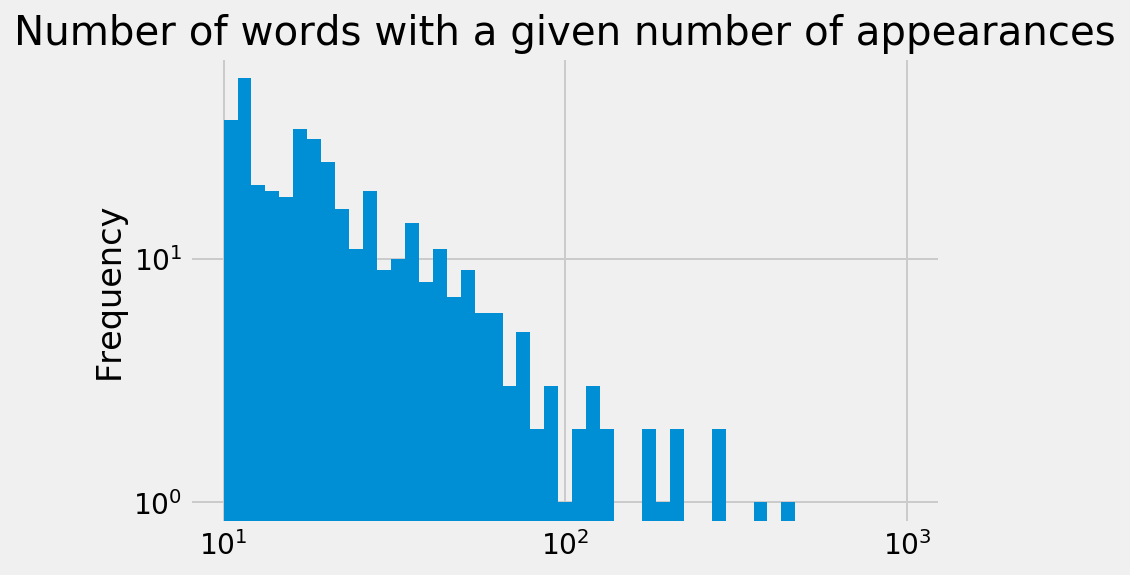

In [83]:
import matplotlib.pyplot as plt
word_freq.plot(kind='hist',
                       bins=np.logspace(1,3,50),
                       loglog=True,
                       title='Number of words with a given number of appearances',
                       fontsize=14)
plt.show()


 in theory the more/less max features???? show compare write

# Tuning Hyperparameters Count Vectorizer 


In [84]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

### N_gram

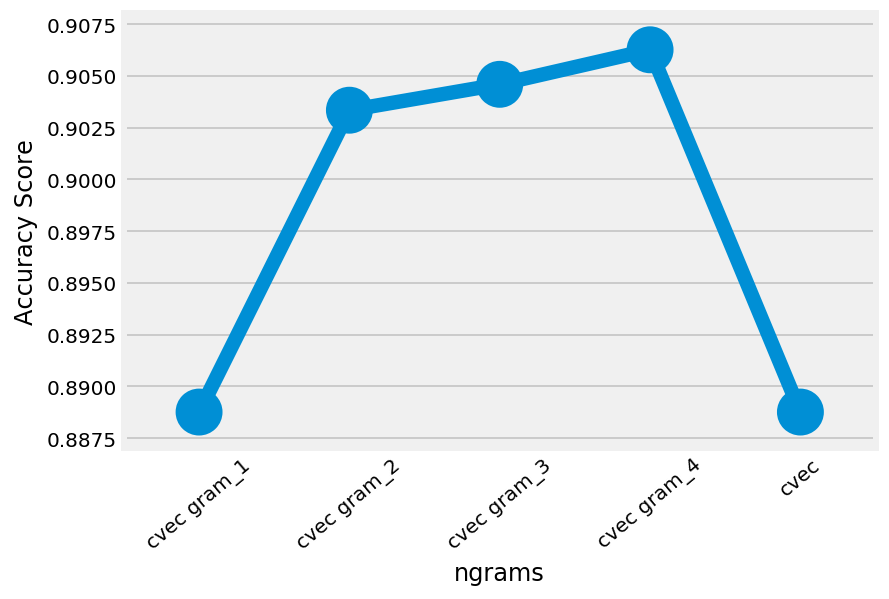

In [85]:
def count_vec_ngram(params, X_train, y_train):
    cvec_p = CountVectorizer(ngram_range=(params)) 

    cvec_p.fit(X_train)
    X_train_cvec_p = cvec_p.transform(X_train)

    # cross val score/ predict
    cvec_score_p = cross_val_score(lr, X_train_cvec_p, y_train, cv=3)

    # cross validation 
    return cvec_score_p.mean()

params = [(1,1), (1,2),(1,3), (1,4)] 
ngram_scores = []
for p in params:
    ngram_scores.append(count_vec_ngram(p, X_train, y_train))
    
ngrams = ['cvec gram_1','cvec gram_2','cvec gram_3','cvec gram_4']
ngram_df = pd.DataFrame({'params':ngrams, 'scores':ngram_scores}, index=[0,1,2,3])
# adding cvec score with default params
ngram_df = ngram_df.append(acc_df.iloc[:1,:])

# plot scores on graph
sns.pointplot(x='params', y='scores', data =ngram_df)
plt.ylabel('Accuracy Score')
plt.xlabel('ngrams')
plt.xticks(rotation=40)
plt.show()

In [86]:
# update accuracy scores with highest score for 1,2 ngram
acc_df1 = acc_df.append(ngram_df.iloc[3,:])
acc_df1.reset_index(inplace=True, drop=True)
acc_df1

,params,scores
0,cvec,0.888761
1,tvec,0.856661
2,cvec gram_4,0.906264


### Max Features

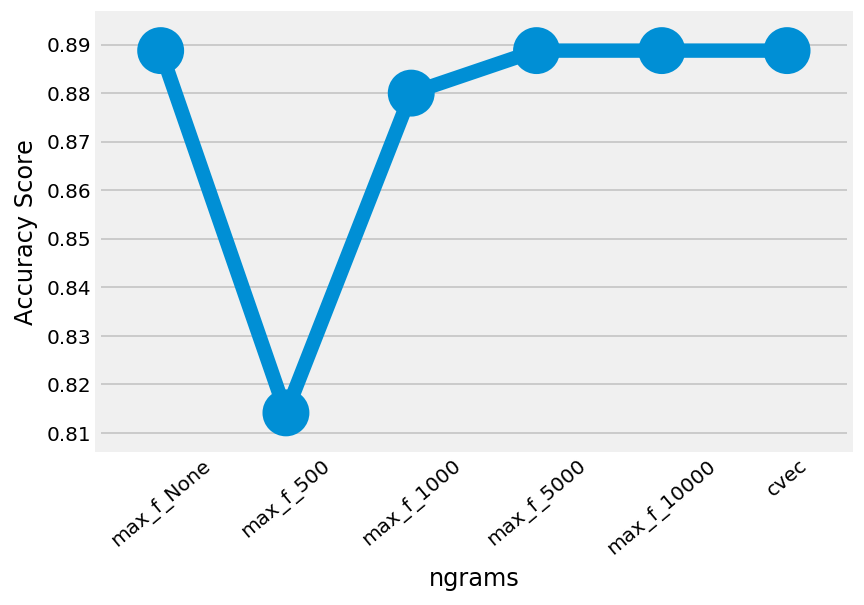

In [87]:
def count_vec_max_features(params, X_train, y_train):
    cvec_p = CountVectorizer(max_features=params) 

    cvec_p.fit(X_train)
    X_train_cvec_p = cvec_p.transform(X_train)

    # cross val score/ predict
    cvec_score_p = cross_val_score(lr, X_train_cvec_p, y_train, cv=3)

    # cross validation 
    return cvec_score_p.mean()

mf_params = [None, 500, 1000, 5000, 10000]
max_features_scores = [count_vec_max_features(p, X_train, y_train) for p in mf_params]
max_features = ['max_f_'+str(p) for p in mf_params]

# dataframe for scores
max_features_df = pd.DataFrame({'params':max_features, 'scores':max_features_scores}, index=[0,1,2,3,4])
# adding cvec score with default params
max_features_df = max_features_df.append(acc_df.iloc[:1,:])

sns.pointplot(x='params', y='scores', data =max_features_df)
plt.ylabel('Accuracy Score')
plt.xlabel('ngrams')
plt.xticks(rotation=40)
plt.show()

In [88]:
# update accuracy dataframe with 3 highest scores
acc_df2 = acc_df1.append(max_features_df.drop(max_features_df.index[[1,2]]))
acc_df2.reset_index(inplace=True, drop=True)
acc_df2

,params,scores
0,cvec,0.888761
1,tvec,0.856661
2,cvec gram_4,0.906264
3,max_f_None,0.888761
4,max_f_5000,0.888761
5,max_f_10000,0.888761
6,cvec,0.888761


### max_df

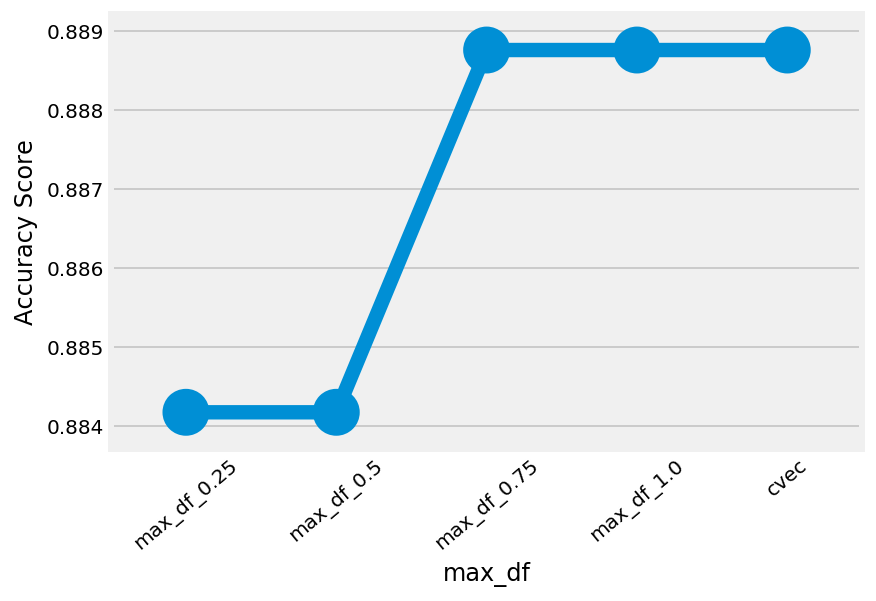

In [89]:
def count_vec_max_df(params, X_train, y_train):
    cvec_p = CountVectorizer(max_df=params) 

    cvec_p.fit(X_train)
    X_train_cvec_p = cvec_p.transform(X_train)

    # cross val score/ predict
    cvec_score_p = cross_val_score(lr, X_train_cvec_p, y_train, cv=3)

    # cross validation 
    return cvec_score_p.mean()

mdf_params = [0.25, 0.5, 0.75, 1.0]
max_df_scores = [count_vec_max_df(p, X_train, y_train) for p in mdf_params]
max_df = ['max_df_'+str(p) for p in mdf_params]

# dataframe for scores
max_df_df = pd.DataFrame({'params':max_df, 'scores':max_df_scores}, index=[0,1,2,3])
# adding cvec score with default params
max_df_df = max_df_df.append(acc_df.iloc[:1,:])

sns.pointplot(x='params', y='scores', data =max_df_df)
plt.ylabel('Accuracy Score')
plt.xlabel('max_df')
plt.xticks(rotation=40)
plt.show()

In [90]:
# update accuracy dataframe
acc_df3 = acc_df2.append(max_df_df.iloc[:2,:])
acc_df3.reset_index(inplace=True, drop=True)
acc_df3

,params,scores
0,cvec,0.888761
1,tvec,0.856661
2,cvec gram_4,0.906264
3,max_f_None,0.888761
4,max_f_5000,0.888761
5,max_f_10000,0.888761
6,cvec,0.888761
7,max_df_0.25,0.884175
8,max_df_0.5,0.884175


# Perform Count Vectorizer with chosen parameters
- ngram_range = (1,2): Bigram had the highest score
- max_features: will not be used as the highest scores were the same as default params. 
- max_df =  0.25: Both 0.25 and 0.5 gave the same score. The general trend of this param is the lower the threshold the higher the score. so between the 0.5 and 0.25 the lowest is chosen

In [91]:
##### Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
# initalise the vectoriser 
cvec_b = CountVectorizer(ngram_range=(1,4), max_df=0.25)
# fit the training data on the model
cvec_b.fit(X_train)

#transform training data into sparse matrix
X_train_cvec = cvec_b.transform(X_train)

# cross val score/ predict
cvec_score = cross_val_score(lr, X_train_cvec, y_train, cv=3)
cvec_score.mean()


acc_df3.loc[8]= ['best_params', cvec_score.mean()]
acc_df3.sort_values('scores', ascending=False)


,params,scores
2,cvec gram_4,0.906264
8,best_params,0.905849
0,cvec,0.888761
3,max_f_None,0.888761
4,max_f_5000,0.888761
5,max_f_10000,0.888761
6,cvec,0.888761
7,max_df_0.25,0.884175
1,tvec,0.856661


# Highest Score of Feature Transform Optimization
- As shown above the combined best parameters higher score

## Logistic Regression Parameters
- l1 and l2 regulization penalties

In [92]:
# Transform features once!
cvec_p = CountVectorizer(ngram_range=(1,4)) 
cvec_p.fit(X_train)
X_train_cvec_p = cvec_p.transform(X_train)

In [93]:
from sklearn.linear_model import LogisticRegressionCV
model_l1 = LogisticRegressionCV(Cs=np.logspace(-10,10,21),penalty = 'l1',solver='liblinear',cv=3) 
model_l1.fit(X_train_cvec_p, y_train)

LogisticRegressionCV(Cs=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
           class_weight=None, cv=3, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l1', random_state=None, refit=True,
           scoring=None, solver='liblinear', tol=0.0001, verbose=0)

In [94]:
model_l2 = LogisticRegressionCV(Cs=np.logspace(-10,10,21), penalty = 'l2',solver='liblinear',cv=3) 
model_l2.fit(X_train_cvec_p, y_train)

LogisticRegressionCV(Cs=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
           class_weight=None, cv=3, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='liblinear', tol=0.0001, verbose=0)

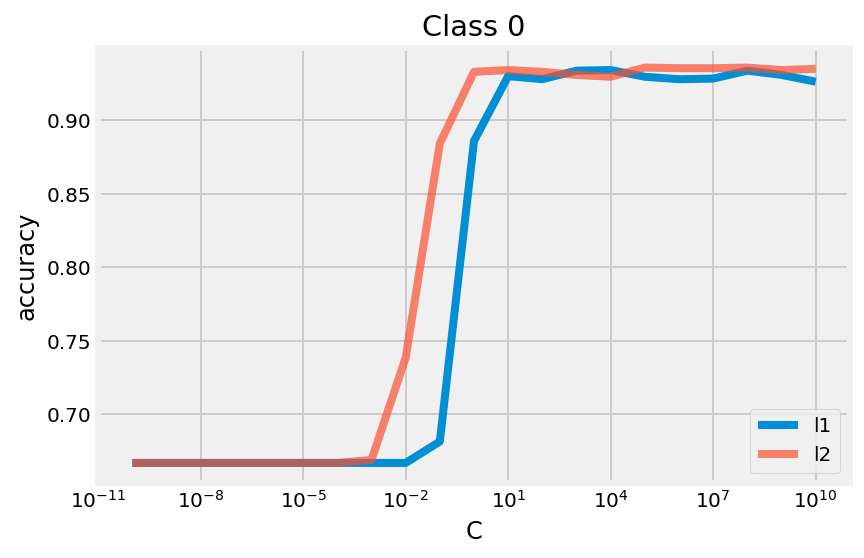

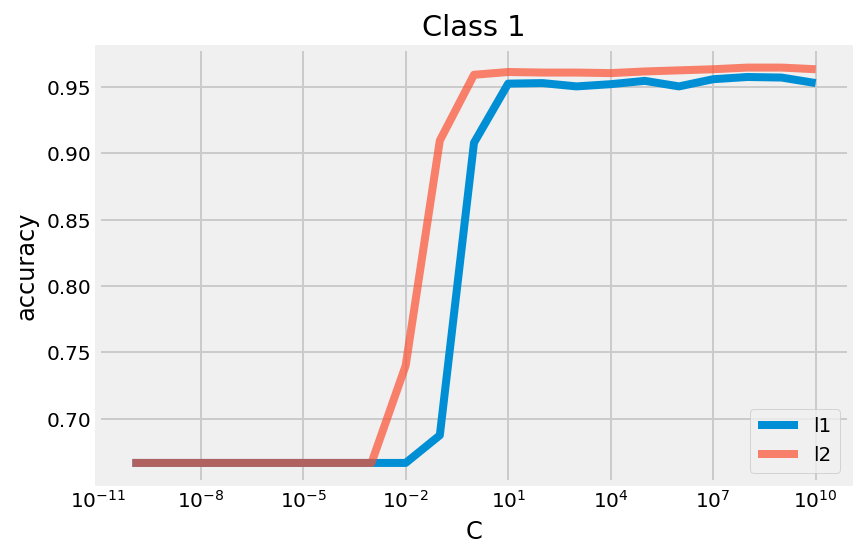

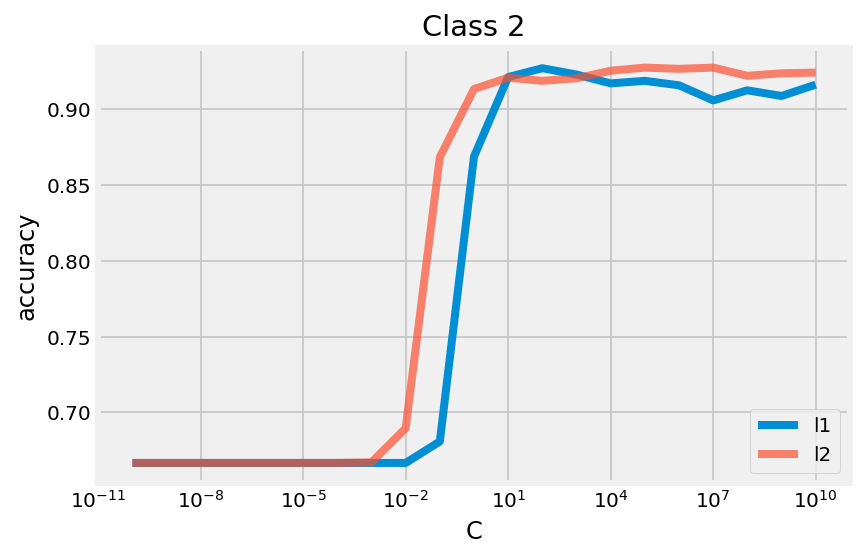

In [95]:
# Comparing the different penalties
for i, cl in enumerate(model_l1.classes_):
    plt.plot(model_l1.Cs_,model_l1.scores_.values()[i].mean(axis=0),label='l1')
    plt.plot(model_l2.Cs_,model_l2.scores_.values()[i].mean(axis=0),alpha=0.7,label='l2')
    plt.xscale('log')
    plt.xlabel('C')
    plt.ylabel('accuracy')
    plt.legend(loc='lower right')
    plt.title('Class {}'.format(cl))
    plt.show()

- the accuracy of l2 is generally higher and more stable.

## Gridsearch on Logistic Regression

In [96]:
lr_params = {'penalty': ['l1','l2'],
          'solver':['liblinear'],
          'C': np.logspace(-10,10,21)}

# Define the gridsearchCV
lr_grid = GridSearchCV(lr, param_grid=lr_params, cv=3, n_jobs=-1, verbose=1)

# fit with the tranformed sparse matrix
lr_grid.fit(X_train_cvec_p, y_train)

print 'Best Score:', lr_grid.best_score_
print

# assign the best estimator to a variable
best_lr = lr_grid.best_estimator_
print 'Best Params:', lr_grid.best_params_

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:    5.4s finished


Best Score: 0.9129166666666667

Best Params: {'penalty': 'l2', 'C': 100000000.0, 'solver': 'liblinear'}


# Features importances
- top 10 for each class

In [145]:
pd.DataFrame(best_lr.coef_)
np.argsort(best_lr.coef_)

array([[12333,  3995,  7529, ...,  9328,  3578, 12332],
       [12332,  7529,  3578, ..., 10046,  3635,  3458],
       [ 3458, 12332,  3578, ..., 12333,  3454,  7529]])

In [177]:
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    
    
    for i, class_label in enumerate(class_labels):
#         output the original index of the top 10 coef
        top10 = np.argsort(clf.coef_[i])[-10:]

        print("%s: %s" % (class_label,
              ", ".join(feature_names[j] for j in top10)))

In [178]:
feature_df = pd.DataFrame()
feature_names = cvec_p.get_feature_names()
for i, class_label in enumerate([0,1,2]):
    index = np.argsort(best_lr.coef_[i])
    feature_df['feature_names'] = [feature_names[j] for j in index]
    class_ = best_lr.coef_[i]
    feature_df['class'+str(i)] = np.abs(class_)
        
feature_df.head()

,feature_names,class0,class1,class2
0,difference,0.796531,1.179130,0.055090
1,thank,0.625469,0.720523,0.002155
2,disappointment,0.625469,0.720523,0.002155
3,do,0.625469,0.720523,0.002155
4,really,0.222195,0.671697,0.310281


In [179]:
class_0_abs_10 = feature_df.sort_values('class0', ascending=False).head(10)
class_1_abs_10 = feature_df.sort_values('class1', ascending=False).head(10)
class_2_abs_10 = feature_df.sort_values('class2', ascending=False).head(10)

0: never be back, never, also be, not, avoid place, horrible, avoid, pizza, disappointment, thank
1: average, service be average, give chance, decent, don get, moderate, moderate price, really, do, difference
2: food, just, classic, try, amazing, fantastic, emilio, thank emilio, die, love


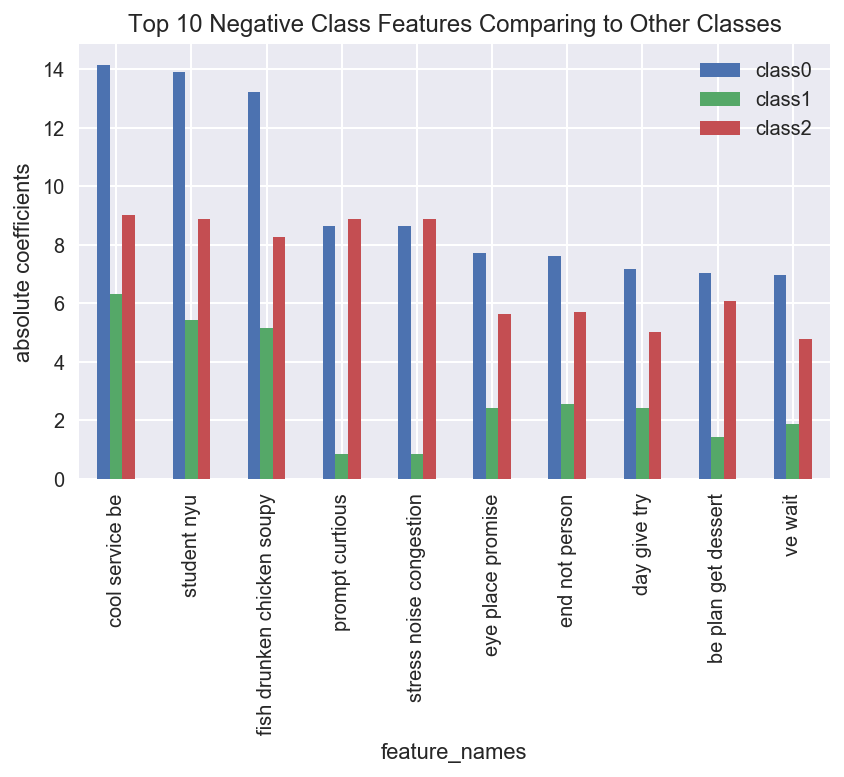

In [180]:
class_0_abs_10.plot(x="feature_names", y=["class0", "class1", "class2"], kind="bar")
plt.ylabel('absolute coefficients')
plt.title('Top 10 Negative Class Features Comparing to Other Classes')
print_top10(cvec_p, best_lr, [0,1,2])

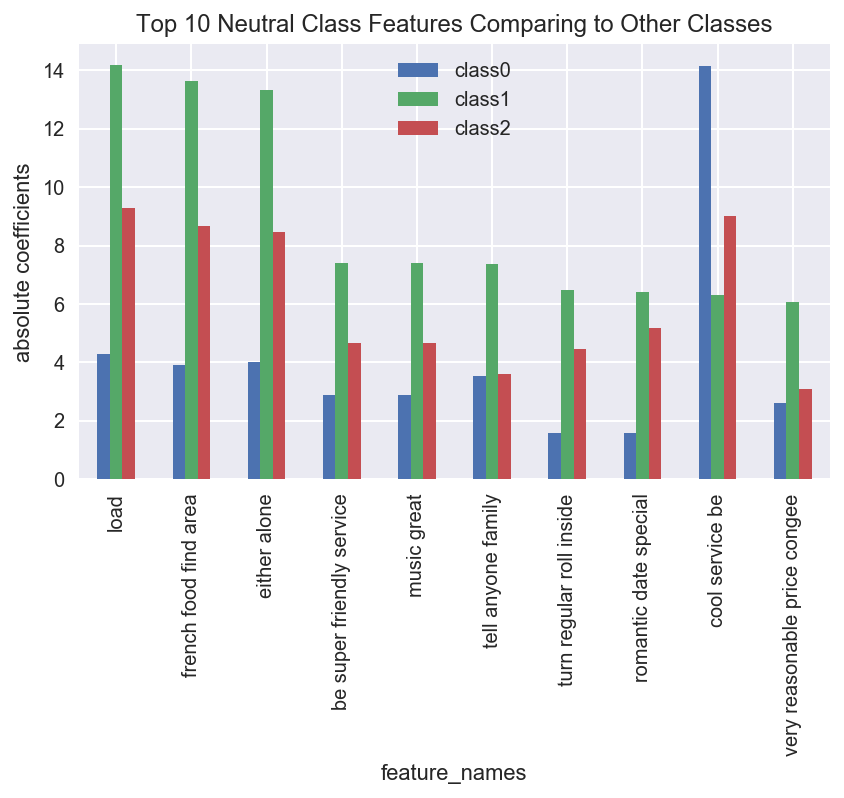

In [181]:

class_1_abs_10.plot(x="feature_names", y=["class0", "class1", "class2"], kind="bar")
plt.ylabel('absolute coefficients')
plt.title('Top 10 Neutral Class Features Comparing to Other Classes')

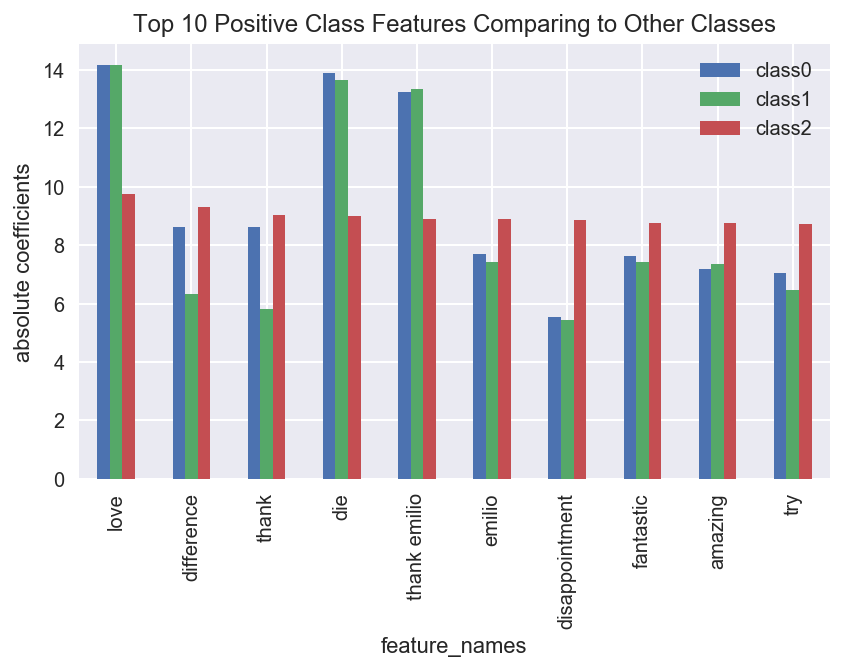

In [175]:
class_2_abs_10.plot(x="feature_names", y=["class0", "class1", "class2"], kind="bar")
plt.ylabel('absolute coefficients')
plt.title('Top 10 Positive Class Features Comparing to Other Classes')

## Evaluation Functions

In [101]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



def plot_precision_recall(model,y_bin,X,f1_lines=True):
    precision = {}
    recall = {}

    for i, cl in enumerate(model.classes_):
        precision[cl], recall[cl], _ = metrics.precision_recall_curve(y_bin[:,i],model.predict_proba(X)[:,i])
    
    average_precision_scores = [round(metrics.average_precision_score(y_bin[:,i],model.predict_proba(X)[:,i]),2) for i in range(len(model.classes_))]
    
    plt.figure(figsize=(6,4))
    for i, key in enumerate(precision.keys()):
        plt.plot(precision[key],recall[key],lw = 2, 
                 label='class {}, average precision score {}'.format(key,average_precision_scores[i]))

    plt.ylim([0,1.05])
    plt.legend(loc='lower left')
    plt.title('Precision-Recall Curve',fontsize=20)
    plt.xlabel('Recall',fontsize=18)
    plt.ylabel('Precision',fontsize=18)
    
    if f1_lines == True:
        for const in [0.2,0.4,0.6,0.8]:
            x_vals = np.linspace(0.001,0.999,100)
            y_vals = 1./(2./const-1./x_vals)
            plt.plot(x_vals[y_vals>0],y_vals[y_vals>0],color='lightblue',ls='--',alpha=0.9)
            plt.ylim([0,1])
            plt.annotate('f1={0:0.1f}'.format(const), xy=(x_vals[-10], y_vals[-2]+0.0))

    plt.show()
    
    
    
def plot_roc(model,y_bin,X):
    fpr = {}
    tpr = {}
    for i, cl in enumerate(model.classes_):
        fpr[cl], tpr[cl], _ = metrics.roc_curve(y_bin[:,i],model.predict_proba(X)[:,i])
    auc_scores = [round(metrics.roc_auc_score(y_bin[:,i],model.predict_proba(X)[:,i]),2) for i in range(len(model.classes_))]
    for i, key in enumerate(fpr.keys()):
        plt.plot(fpr[key],tpr[key],lw=2,label='class {}, ROC_AUC {}'.format(key,auc_scores[i]))
    plt.plot([0,1],[0,1],ls='--',lw=2)
    plt.ylim([0,1.05])
    plt.legend(loc='lower right')
    plt.title('ROC Curve',fontsize=20)
    plt.xlabel('FPR',fontsize=18)
    plt.ylabel('TPR',fontsize=18)
    
    plt.show()

## Evaluate using Cross Validation
- Confusion Matrix
- Classification Report
- Precision Recall Curve 
- ROC Curve

Confusion matrix, without normalization
[[733  33  34]
 [ 19 764  17]
 [ 59  32 709]]


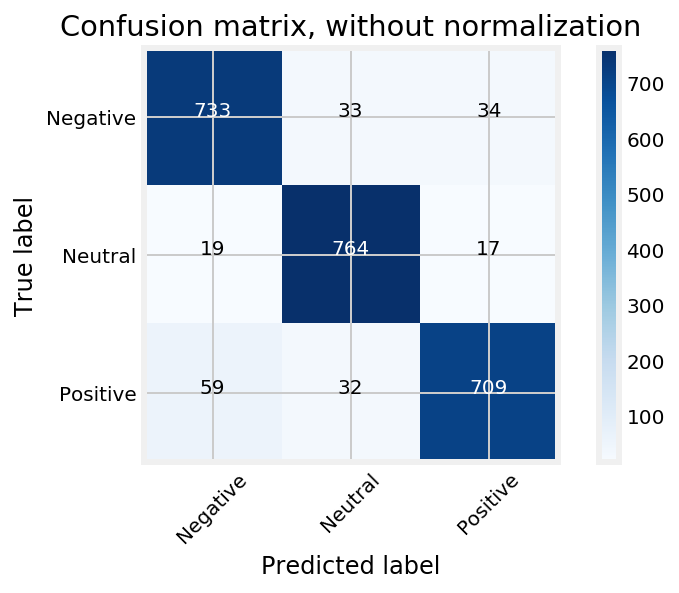

Normalized confusion matrix
[[0.91625 0.04125 0.0425 ]
 [0.02375 0.955   0.02125]
 [0.07375 0.04    0.88625]]


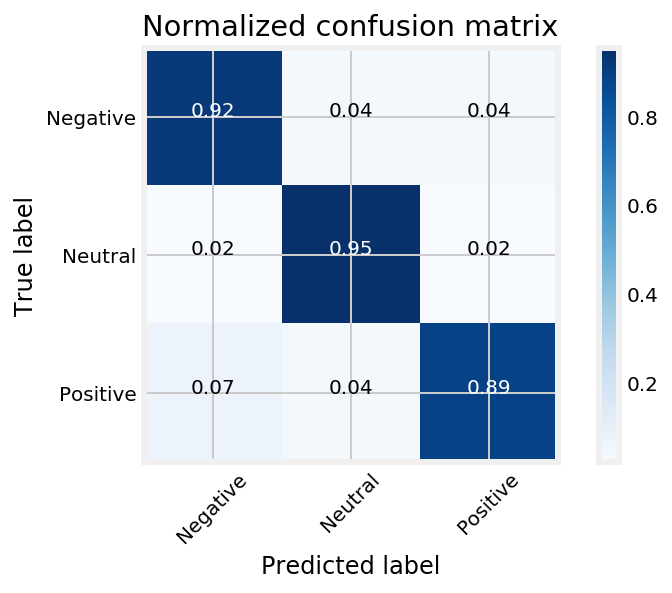

             precision    recall  f1-score   support

          0       0.90      0.92      0.91       800
          1       0.92      0.95      0.94       800
          2       0.93      0.89      0.91       800

avg / total       0.92      0.92      0.92      2400



In [102]:
predictions_estimator = cross_val_predict(best_lr,X_train_cvec_p,y_train,cv=5)

# Compute confusion matrix
cm_cv = confusion_matrix(y_train,predictions_estimator)
x_class = ['Negative', 'Neutral', 'Positive']

# Plot non-normalized confusion matrix
plot_confusion_matrix(cm_cv, classes=x_class, title='Confusion matrix, without normalization')
plt.show()

# Plot normalized confusion matrix
plot_confusion_matrix(cm_cv, classes=x_class, normalize=True, title='Normalized confusion matrix')
plt.show()

print classification_report(y_train,predictions_estimator)

In [103]:
from sklearn.preprocessing import label_binarize
from sklearn import metrics 
y_bin = label_binarize(y_train,best_lr.classes_)

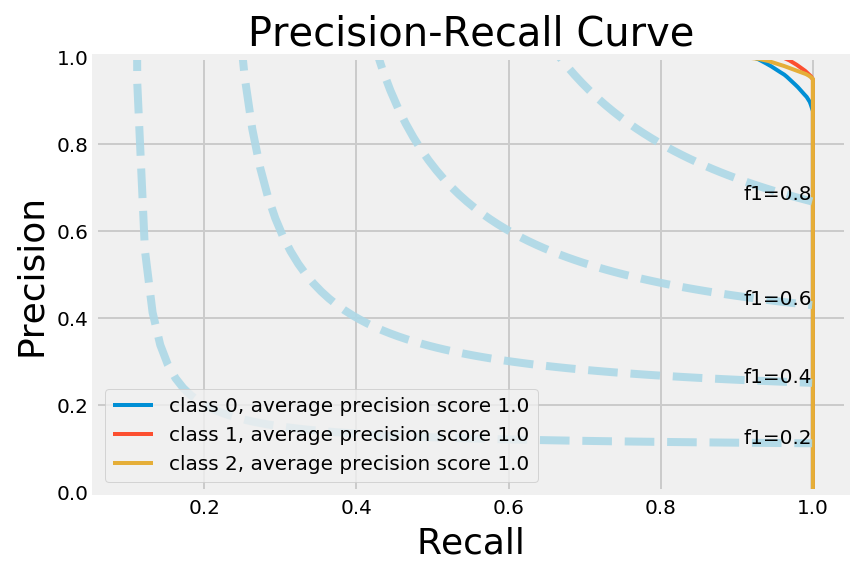

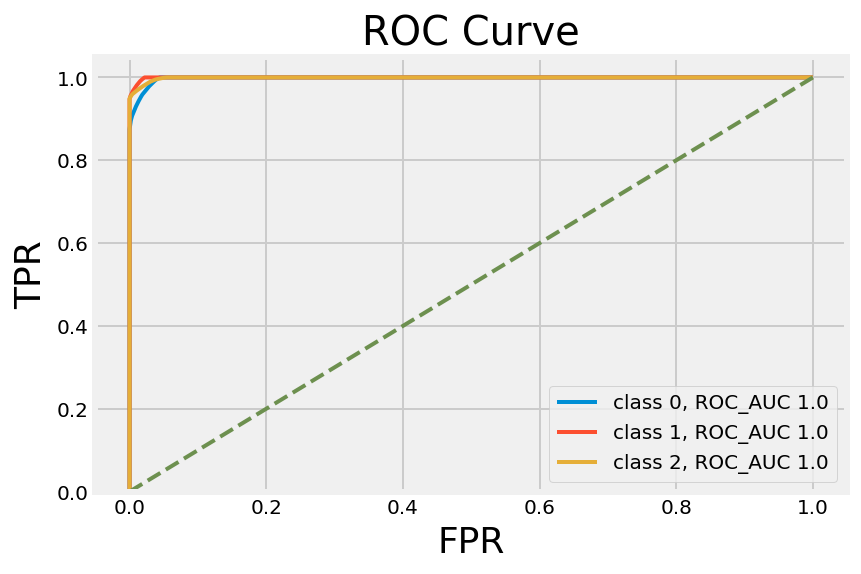

In [104]:
plot_precision_recall(best_lr,y_bin,X_train_cvec_p)
plot_roc(best_lr,y_bin,X_train_cvec_p)

These scores have improved 30% over the baseline

# Evaluate on Test set

In [106]:
testing = pd.read_csv('./train_test_data/testing.csv')
testing.head(3)

,sentence,sentiment,lem_words,lem_tags,word_tags
0,They even scoop it out nice (for those on a di...,2,even scoop out nice diet not too much not little,RB VB RB JJ NN RB RB JJ RB JJ,"[even/RB, scoop/VB, out/RB, nice/JJ, diet/NN, ..."
1,We won't go to this place again for a good meal.,0,win go place again good meal,VB VB NN RB JJ NN,"[win/VB, go/VB, place/NN, again/RB, good/JJ, m..."
2,The menu has so many fish items and oysters.,2,menu have so many fish item oyster,NN VB RB JJ JJ NN NN,"[menu/NN, have/VB, so/RB, many/JJ, fish/JJ, it..."


In [107]:
X_test = testing.lem_words
y_test = testing['sentiment']

In [108]:
# transform with cvec and predict on best log reg
X_test_mat = cvec_p.transform(X_test)
y_pred = best_lr.predict(X_test_mat)

print 'Best CVal on training:', lr_grid.best_score_
print 'Best Model on testing:', accuracy_score(y_test, y_pred)
print "Number of classification errors:", np.abs(y_pred - y_test).sum() 
print 'Total:', len(y_test)

Best CVal on training: 0.9129166666666667
Best Model on testing: 0.6076555023923444
Number of classification errors: 253
Total: 418


- The model created had had a high accuracy score of 0.94 
- after scoring on test set it lowered to 0.67 
- which is still significantly higher than the baseline of 0.3
- however shows the model is overfitting on the training data

### Confusions matirix 
- I will evaluate my model through showing the accuracy

Confusion matrix, without normalization
[[ 30  19  39]
 [ 11  25  26]
 [ 50  19 199]]


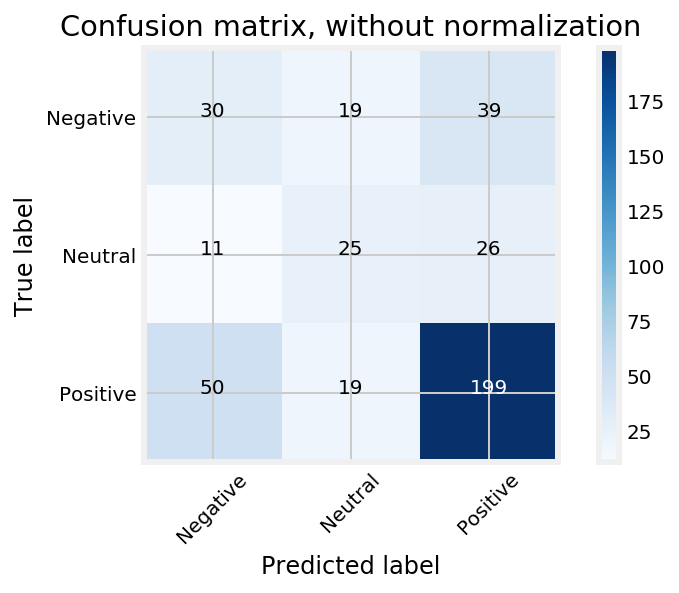

Normalized confusion matrix
[[0.34 0.22 0.44]
 [0.18 0.4  0.42]
 [0.19 0.07 0.74]]


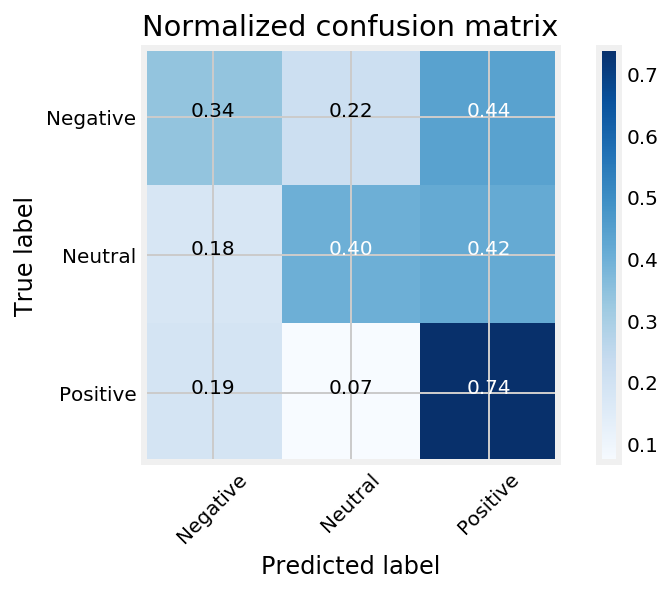

             precision    recall  f1-score   support

          0       0.33      0.34      0.34        88
          1       0.40      0.40      0.40        62
          2       0.75      0.74      0.75       268

avg / total       0.61      0.61      0.61       418



In [109]:
cm_t = confusion_matrix(y_test,y_pred)
x_class = ['Negative', 'Neutral', 'Positive']
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cm_t, classes=x_class, title='Confusion matrix, without normalization')
plt.show()

# Plot normalized confusion matrix
plot_confusion_matrix(cm_t, classes=x_class, normalize=True, title='Normalized confusion matrix')
plt.show()

print classification_report(y_test,y_pred)

In comparrison to the Training data 


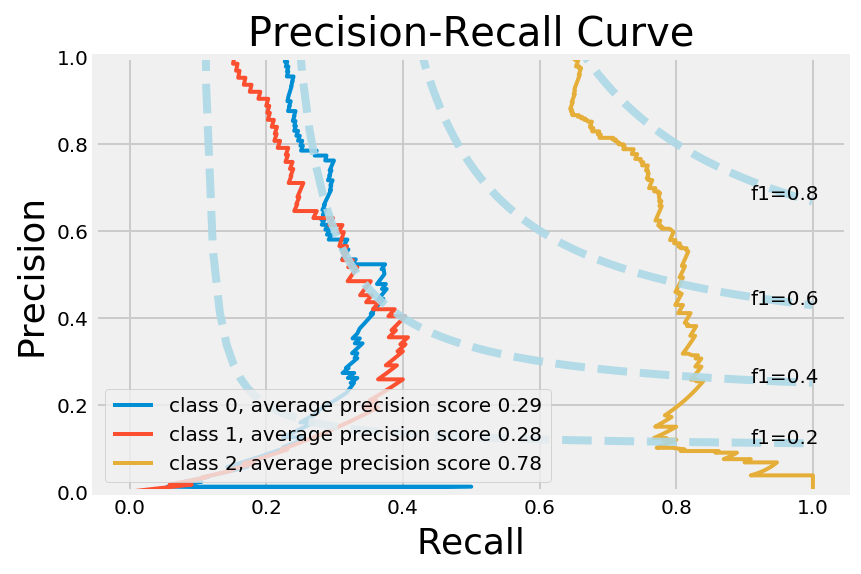

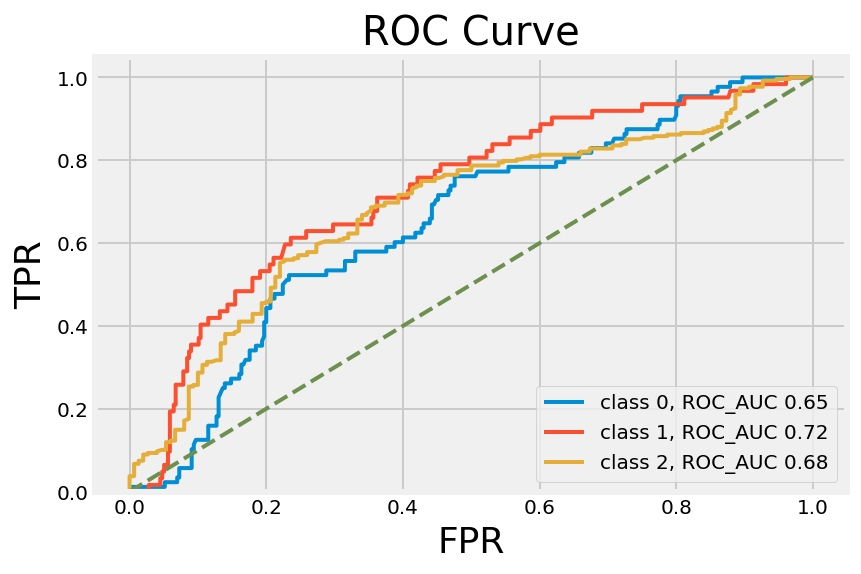

In [110]:
from sklearn.preprocessing import label_binarize
from sklearn import metrics 
y_bin = label_binarize(y_test,best_lr.classes_)

plot_precision_recall(best_lr,y_bin,X_test_mat)
plot_roc(best_lr,y_bin,X_test_mat)

## Foursquare data
    - polarity : Target 2:positive, 1:neutral, 0:negative
    - words : preprocessed sentences
    - type : the tags of the words from lemmatizing 


TFDIF was fitted on the training data which will be used to transfomation the words in testing into a sparse matrix
Logistic Regressions best parameters which were fit for the training data will then predict sentiment (y_hat) for the transformed testing data.



---- logistic regression gave a good score in classifying the predictors but will try different classifiers to determine best accuracy score 


In [114]:
foursquare = pd.read_csv('./foursquare/foursquare_csv/foursquare_clean.csv', encoding='utf8')
print foursquare.shape
foursquare.head(3)

(5176, 6)


,tips,lem_words,lem_tags,word_tags,lng,lat
0,Great fun to be had by everyone. The aquarium ...,great fun be have everyone aquarium be small f...,JJ NN VB VB NN NN VB JJ NN VB NN VB NN NN VB NN,"[great/JJ, fun/NN, be/VB, have/VB, everyone/NN...",51.440982,-0.061369
1,Love this place my new local shop,love place new local shop,VB NN JJ JJ NN,"[love/VB, place/NN, new/JJ, local/JJ, shop/NN]",51.466901,0.052826
2,Enter our prize draw to win a family ticket to...,prize draw win family ticket sea life don win ...,NN NN VB NN NN NN NN VB VB RB VB RB VB JJ NN V...,"[prize/NN, draw/NN, win/VB, family/NN, ticket/...",51.501711,-0.119767


In [115]:
X = foursquare.lem_words

# transform with chosen cvec and predict on best log reg
X_fs_mat = cvec_p.transform(X)
y_fs_pred = best_lr.predict(X_fs_mat)

foursquare['polarity_pred'] = y_fs_pred
foursquare.head(3)

,tips,lem_words,lem_tags,word_tags,lng,lat,polarity_pred
0,Great fun to be had by everyone. The aquarium ...,great fun be have everyone aquarium be small f...,JJ NN VB VB NN NN VB JJ NN VB NN VB NN NN VB NN,"[great/JJ, fun/NN, be/VB, have/VB, everyone/NN...",51.440982,-0.061369,2
1,Love this place my new local shop,love place new local shop,VB NN JJ JJ NN,"[love/VB, place/NN, new/JJ, local/JJ, shop/NN]",51.466901,0.052826,2
2,Enter our prize draw to win a family ticket to...,prize draw win family ticket sea life don win ...,NN NN VB NN NN NN NN VB VB RB VB RB VB JJ NN V...,"[prize/NN, draw/NN, win/VB, family/NN, ticket/...",51.501711,-0.119767,1


In [116]:
print 'Accuracy Score of Model which reflect on New Data Predictions'
print 'Best CVal on training:', lr_grid.best_score_
print 'Best Model on testing:', accuracy_score(y_test, y_pred)
print "Number of classification errors:", np.abs(y_pred - y_test).sum() 
print 'Total:', len(y_test)

Accuracy Score of Model which reflect on New Data Predictions
Best CVal on training: 0.9129166666666667
Best Model on testing: 0.6076555023923444
Number of classification errors: 253
Total: 418


## Save Foursquare Predictions

In [117]:
foursquare.to_csv('foursquare_predictions.csv', header=True, index=False, encoding='UTF8')

df_neutral= foursquare[foursquare.polarity_pred ==1]
df_positive= foursquare[foursquare.polarity_pred ==2]
df_negative= foursquare[foursquare.polarity_pred ==0]

# created to make graphs on tableau
df_neutral.to_csv('./foursquare/fouresquare_predictions/df_neutral.csv', header=True, index=False, encoding='UTF8')
df_positive.to_csv('./foursquare/fouresquare_predictions/df_positive.csv', header=True, index=False, encoding='UTF8')
df_negative.to_csv('./foursquare/fouresquare_predictions/df_negative.csv', header=True, index=False, encoding='UTF8')

# Visualisations 

In [118]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [119]:
foursquare.groupby(['polarity_pred']).count()

,tips,lem_words,lem_tags,word_tags,lng,lat
polarity_pred,,,,,,
0,637,637,637,637,637,637
1,738,738,738,738,738,738
2,3801,3801,3801,3801,3801,3801


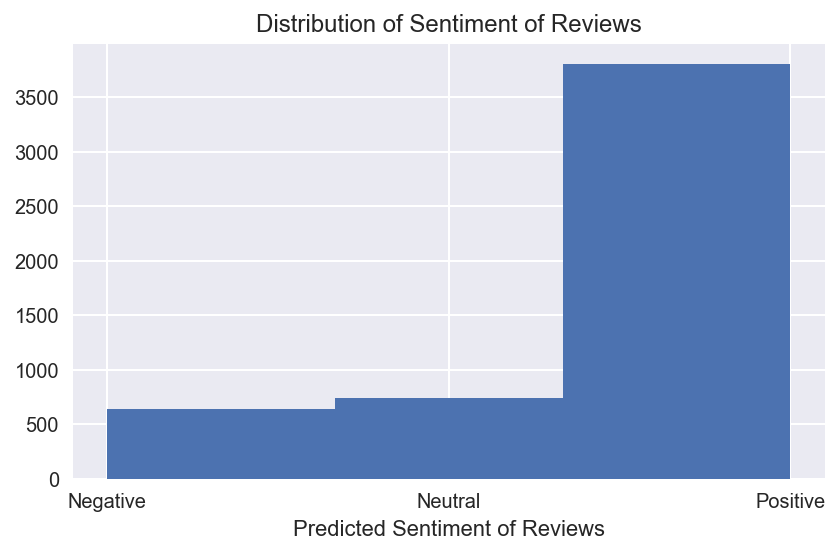

In [120]:
plt.hist(foursquare.polarity_pred, bins = 3, align= 'mid')
plt.xticks(range(3), ['Negative','Neutral', 'Positive'])
plt.xlabel('Predicted Sentiment of Reviews')
plt.title('Distribution of Sentiment of Reviews')
plt.show()